## Data Description

### Labels

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot 


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(['ls', './input']).decode('utf8'))

# Any results you write to the current directory are saved as output.

fashion-mnist_test.csv
fashion-mnist_train.csv
t10k-images-idx3-ubyte
t10k-labels-idx1-ubyte.dms
train-images-idx3-ubyte
train-labels-idx1-ubyte.dms



In [35]:
data_train_file = './input/fashion-mnist_train.csv'
data_test_file = './input/fashion-mnist_test.csv'

df_train = pd.read_csv(data_train_file)
shuffle_index = np.random.permutation(df_train.shape[0])
df_train = df_train.iloc[shuffle_index]

df_test = pd.read_csv(data_test_file)

# Take a look at some instance of the dataset

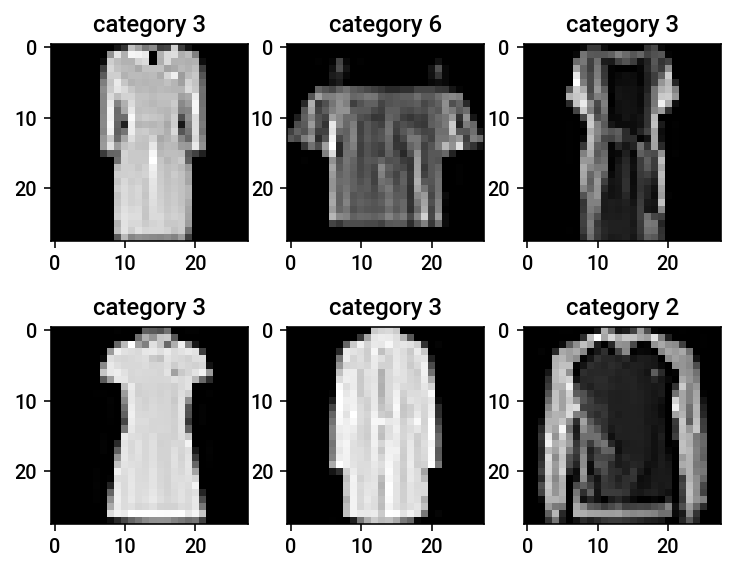

In [67]:
samples = np.random.randint(0, df_train.shape[0], 6)
# sample = np.reshape(df_train.iloc[samples[0], 1:].values/255, (28, 28))
# plt.imshow(sample, 'gray')
for i, idx in enumerate(samples):
    sample = np.reshape(df_train.iloc[idx, 1:].values/255, (28, 28))
    plt.subplot(2, 3, i+1)
    plt.title('category {}'.format(df_train.iloc[idx, 0]))
    plt.subplots_adjust(top=1, bottom=0.1)
    plt.imshow(sample, 'gray')

## Visualize the ten-categoires with t-SNE

t-distributed stochastic neighbor embedding (t-SNE), proposed by Laurens [t-SNE](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf), is a non-linear embedding algorithm that is able to preserve points within clusters.


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


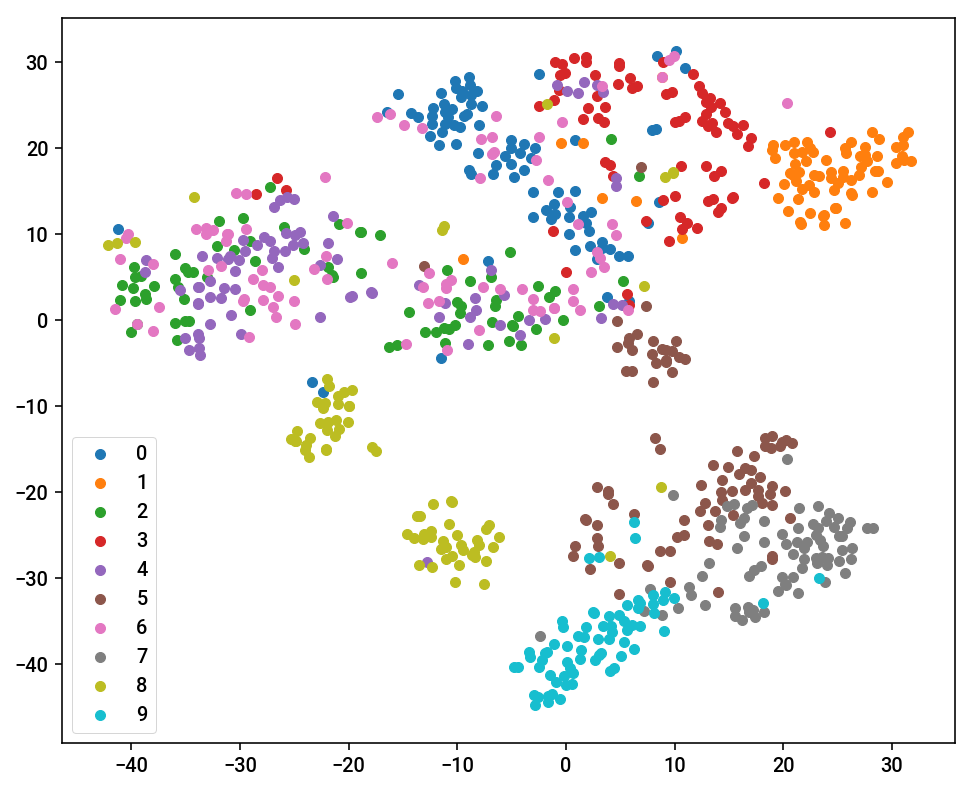

In [61]:
# Use a small subset for visualization

X = df_train.iloc[:800, 1:]
y = df_train.iloc[:800, 0]

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)

target_ids = range(10)

fig, ax = plt.subplots(figsize=(8, 8/1.2))
for i, c, label in zip(target_ids, colors, range(10)):
    ax.scatter(X_2d[y==i, 0], X_2d[y == i, 1], cmap='viridis', label=label)
    ax.legend()
    fig.show()

It seesms like category 6 (shirt) is not quite easy to separate with other categoires, as it scatters around in other types of items. This is possible that a shirt differs from other clothes only in length.

## Data Preprocessing

In [155]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

train_data, val_data = train_test_split(df_train.iloc[:, 1:], test_size=0.2, random_state=42)
train_data, val_data = train_data/255, val_data/255 # normalize training and validation data
train_label, val_label = train_test_split(df_train.iloc[:, 0], test_size=0.2, random_state=42)

test_data = df_test.iloc[:, 1:]
test_label = df_test.iloc[:, 0]
test_data /= 255 # normalize test data


train_label_cat = to_categorical(train_label)
val_label_cat = to_categorical(val_label)
test_label_cat = to_categorical(test_label)

## Mutiple-output flavored logistic regression (softmax_regression)

In [8]:
from sklearn.linear_model import LogisticRegression
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(train_data, train_label)
n_cat = 10
y_pred_soft = softmax_reg.predict(test_data)

## Use a stochastic gradient descent classifier (SGDClassifier)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(train_data, train_label)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [12]:
## accuracy
from sklearn.metrics import confusion_matrix

correct = np.sum(df_test.iloc[:, 0] == y_pred_soft) 
wrong = np.sum(df_test.iloc[:, 0] != y_pred_soft)

confusion_matrix(df_test.iloc[:, 0], y_pred_soft)

array([[828,   5,  13,  44,   0,   2,  93,   0,  14,   1],
       [  1, 968,   6,  18,   0,   2,   5,   0,   0,   0],
       [ 17,   1, 763,   8, 116,   0,  84,   0,  11,   0],
       [ 30,  21,  16, 884,  21,   0,  27,   0,   1,   0],
       [  1,   0,  69,  29, 814,   0,  84,   0,   3,   0],
       [  2,   0,   0,   1,   0, 926,   1,  44,   8,  18],
       [164,   7, 106,  30,  93,   1, 586,   0,  13,   0],
       [  0,   0,   0,   0,   0,  45,   0, 906,   1,  48],
       [  5,   0,   7,   4,   4,   7,  19,   5, 947,   2],
       [  0,   0,   0,   0,   0,  18,   0,  36,   1, 945]])

## Use RadomForest for multiple-output classification

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# {"criterion":"entropy","max_depth":50,"n_estimators":100}

rf_clf = RandomForestClassifier(n_estimators=100, max_depth = 50, 
                                criterion='entropy', n_jobs=-1)
rf_clf.fit(train_data, train_label_cat)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
label_names = ['Class-{}'.format(i) for i in range(1, 11)]
#y_actual = df_test.iloc[:, 0]
y_pred_rf = rf_clf.predict(test_data)

def sparse_matrix_vec(mat):
    n, m = mat.shape
    vec = np.zeros(n)
    for i in range(n):
        for j in range(m):
            if mat[i, j]:
                vec[i] = j
    return vec

y_pred_rf_vec = sparse_matrix_vec(y_pred_rf)
correct = np.nonzero(test_label == y_pred_rf_vec)[0]
wrong = np.nonzero(test_label != y_pred_rf_vec)[0]

print(classification_report(test_label, y_pred_rf_vec, target_names=label_names))
print(accuracy_score(test_label, y_pred_rf_vec))

             precision    recall  f1-score   support

    Class-1       0.46      0.96      0.62      1000
    Class-2       1.00      0.95      0.97      1000
    Class-3       0.88      0.70      0.78      1000
    Class-4       0.95      0.85      0.90      1000
    Class-5       0.86      0.75      0.80      1000
    Class-6       0.99      0.91      0.95      1000
    Class-7       0.87      0.44      0.59      1000
    Class-8       0.93      0.91      0.92      1000
    Class-9       0.98      0.95      0.97      1000
   Class-10       0.95      0.94      0.95      1000

avg / total       0.89      0.84      0.84     10000

0.838


## Check RF works for what kinds of image and on which it does not

### Works

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


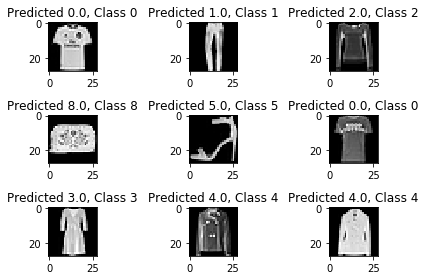

In [87]:
for i, good in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data.iloc[good].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_pred_rf_vec[good], test_label[good]))
    plt.tight_layout()

### Not Work


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


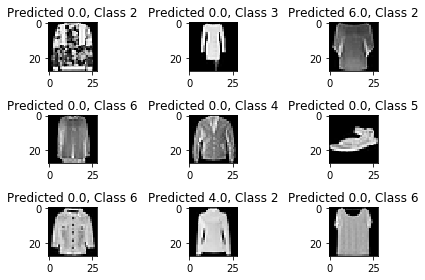

In [88]:
for i, bad in enumerate(wrong[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data.iloc[bad].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_pred_rf_vec[bad], test_label[bad]))
    plt.tight_layout()

## Use XGBoost

In [112]:
#from xgboost.sklearn import XGBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier

params = {"loss":"deviance",
          "max_depth":10,
#           'updater' = 'grow_gpu', # use gpu
          "n_estimators":100}
xgb_clf = XGBClassifier(**params) # {"loss":"deviance","max_depth":10,"n_estimators":100}
xgb_clf.fit(train_data, train_label)

# xgb_clf.fit(train_data, train_label,
#         eval_set=[(X_train, y_train), (val_data, val_label)],
#         eval_metric='categorical_crossentropy',
#         verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, loss='deviance',
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [106]:
help(XGBClassifier)
# default parameters used by XGBClassifier
params2 = {'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'multi:softprob',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  
 |      Parameters
 |  ----------
 |  max_depth : int
 |      Maximum tree depth for base learners.
 |  learning_rate : float
 |      Boosting learning rate (xgb's "eta")
 |  n_estimators : int
 |      Number of boosted trees to fit.
 |  silent : boolean
 |      Whether to print messages while running boosting.
 |  objective : string or callable
 |      Specify the learning task and the corresponding learning objective or
 |      a custom objective function to be used (see note below).
 |  booster: string
 |      Specify which booster to use: gbtree, gblinear or dart.
 |  nthread : int
 |      Number of parallel threads used to run xgboost.  (Deprecated, please use n_jobs)
 |  n_jobs : int
 |      Number of parallel threads used to run xgboost.  (replaces nthread)
 |  gamma : float
 |      Minimum

In [108]:
xgb_clf.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'multi:softprob',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

In [113]:
y_pred_xgb = xgb_clf.predict(test_data)
y_pred_xgb[:5]

correct = np.nonzero(test_label == y_pred_xgb)[0]
wrong = np.nonzero(test_label != y_pred_xgb)[0]

print(classification_report(test_label, y_pred_xgb, target_names=label_names))
print(accuracy_score(test_label, y_pred_xgb))

             precision    recall  f1-score   support

    Class-1       0.83      0.87      0.85      1000
    Class-2       0.99      0.98      0.98      1000
    Class-3       0.83      0.82      0.83      1000
    Class-4       0.91      0.92      0.91      1000
    Class-5       0.83      0.88      0.85      1000
    Class-6       0.98      0.95      0.97      1000
    Class-7       0.76      0.67      0.71      1000
    Class-8       0.94      0.95      0.94      1000
    Class-9       0.96      0.98      0.97      1000
   Class-10       0.95      0.96      0.96      1000

avg / total       0.90      0.90      0.90     10000

0.8983


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


- XGBoost achieved testing accuracy of 0.8983, which is better than the random forest. As the classification report shows, xgboost did not work well in calssifying class-7 (**sneakers**), the precision and recall is only about 0.76 and 0.67, respectively.

## Use Keras
### Densely Connected Network

In [156]:
from keras.utils import to_categorical

train_label = to_categorical(train_label.copy())
val_label = to_categorical(val_label.copy())
test_label = to_categorical(test_label.copy())

# model configuration
(N, D_in), H1, D_out = train_data.shape, 1000, 10

In [157]:
from keras import models
from keras import layers
from keras import optimizers
# from keras.utils import multi_gpu_model

model = models.Sequential()
model.add(layers.Dense(H1, input_shape=(D_in, ), activation='relu'))
model.add(layers.Dense(D_out, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam(lr=1e-3)
             )

history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=128, epochs=20, shuffle=True)

score = model.evaluate(test_data, test_label, verbose=0)

print('Dense NN only\n test accuracy={:.3f}, test loss={:.3f}'
          .format(score[1], score[0]))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 4s 80us/step - loss: 0.5211 - acc: 0.8166 - val_loss: 0.4327 - val_acc: 0.8467
Epoch 2/20
48000/48000 [==============================] - 3s 68us/step - loss: 0.3822 - acc: 0.8600 - val_loss: 0.3514 - val_acc: 0.8753
Epoch 3/20
48000/48000 [==============================] - 3s 68us/step - loss: 0.3424 - acc: 0.8755 - val_loss: 0.3412 - val_acc: 0.8787
Epoch 4/20
48000/48000 [==============================] - 3s 68us/step - loss: 0.3166 - acc: 0.8839 - val_loss: 0.3712 - val_acc: 0.8646
Epoch 5/20
48000/48000 [==============================] - 3s 67us/step - loss: 0.2970 - acc: 0.8913 - val_loss: 0.3114 - val_acc: 0.8879
Epoch 6/20
48000/48000 [==============================] - 3s 68us/step - loss: 0.2787 - acc: 0.8968 - val_loss: 0.3244 - val_acc: 0.8835
Epoch 7/20
48000/48000 [==============================] - 3s 67us/step - loss: 0.2655 - acc: 0.9012 - val_loss: 0.2960 - val_acc

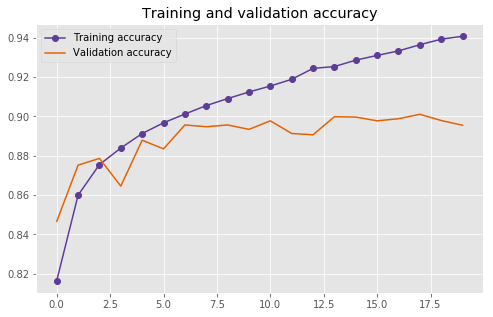

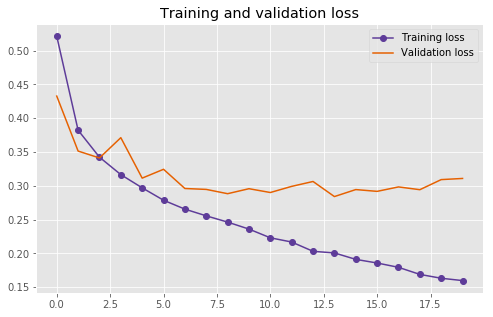

In [158]:
def plot_train_curve(history):
    colors = ['#e66101','#fdb863','#b2abd2','#5e3c99']
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))
    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, accuracy, marker='o', c=colors[3], label='Training accuracy')
        plt.plot(epochs, val_accuracy, c=colors[0], label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, loss, marker='o', c=colors[3], label='Training loss')
        plt.plot(epochs, val_loss, c=colors[0], label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()
    
plot_train_curve(history)    

In [159]:
y_pred_dnn = model.predict_classes(test_data)
print(classification_report(df_test.iloc[:, 0], y_pred_dnn, target_names=label_names))

             precision    recall  f1-score   support

    Class-1       0.92      0.74      0.82      1000
    Class-2       0.99      0.98      0.98      1000
    Class-3       0.89      0.80      0.84      1000
    Class-4       0.91      0.92      0.91      1000
    Class-5       0.85      0.83      0.84      1000
    Class-6       0.99      0.92      0.95      1000
    Class-7       0.64      0.85      0.73      1000
    Class-8       0.93      0.94      0.93      1000
    Class-9       0.98      0.97      0.98      1000
   Class-10       0.92      0.98      0.95      1000

avg / total       0.90      0.89      0.89     10000



This simple densely connected neural network achieved sightly higher accuracy score, but the improve the class-7 is still marginal.  We could add more nuerons and more layers, but DNN may not be a good idea in computation efficiency. The convolutional neural network is specifically designed for computer vision, which is the must-go for this dataset.
Additionally, we can try to use dropout out layers after each pooling layer, and do images augmentation . So the possible steps to improve is:
- more neurons in each layer
- add dropout 
- augmentation

### Use CNN

In [160]:
## reshape data to 28 * 28 * 1
train_data = np.array(train_data).reshape(train_data.shape[0], 28, 28, 1)
val_data = np.array(val_data).reshape(val_data.shape[0], 28, 28, 1)
test_data = np.array(test_data).reshape(test_data.shape[0], 28, 28, 1)

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(D_out, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.RMSprop(lr=1e-3))

history = model.fit(train_data, train_label,
                    validation_data=(val_data, val_label),
                    batch_size=64, epochs=10, shuffle=True)

score = model.evaluate(test_data, test_label, verbose=0)
print('CNN using no dropout\n test accuracy={:.3f}, test loss={:.3f}'
          .format(score[1], score[0]))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 10s 214us/step - loss: 0.5325 - acc: 0.8056 - val_loss: 0.3483 - val_acc: 0.8758
Epoch 2/10
48000/48000 [==============================] - 9s 198us/step - loss: 0.3414 - acc: 0.8781 - val_loss: 0.3043 - val_acc: 0.8926
Epoch 3/10
48000/48000 [==============================] - 9s 198us/step - loss: 0.2892 - acc: 0.8950 - val_loss: 0.2800 - val_acc: 0.8982
Epoch 4/10
48000/48000 [==============================] - 10s 198us/step - loss: 0.2578 - acc: 0.9081 - val_loss: 0.2701 - val_acc: 0.9024
Epoch 5/10
48000/48000 [==============================] - 9s 198us/step - loss: 0.2327 - acc: 0.9148 - val_loss: 0.3255 - val_acc: 0.8846
Epoch 6/10
48000/48000 [==============================] - 9s 198us/step - loss: 0.2142 - acc: 0.9218 - val_loss: 0.2556 - val_acc: 0.9095
Epoch 7/10
48000/48000 [==============================] - 10s 200us/step - loss: 0.1959 - acc: 0.9274 - val_loss: 0.2593

             precision    recall  f1-score   support

    Class-1       0.81      0.92      0.87      1000
    Class-2       0.99      0.99      0.99      1000
    Class-3       0.86      0.88      0.87      1000
    Class-4       0.92      0.94      0.93      1000
    Class-5       0.86      0.88      0.87      1000
    Class-6       0.99      0.97      0.98      1000
    Class-7       0.84      0.66      0.74      1000
    Class-8       0.95      0.97      0.96      1000
    Class-9       0.99      0.98      0.98      1000
   Class-10       0.97      0.97      0.97      1000

avg / total       0.92      0.92      0.91     10000



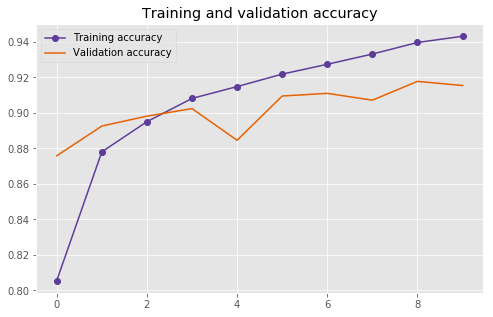

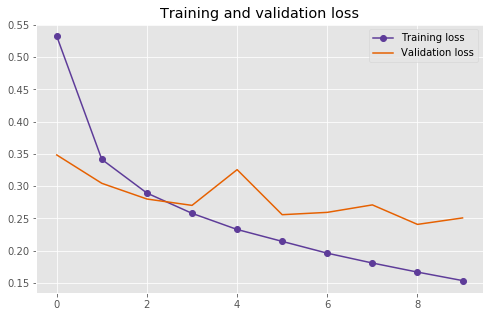

In [161]:
y_pred_cnn = model.predict_classes(test_data)
print(classification_report(df_test.iloc[:, 0], y_pred_cnn, target_names=label_names))

plot_train_curve(history)

### Add dropout layer to CNN to reduce overfitting

The training curve indicates the model started  overfitting at **epoch=3**. We need to fix this. Let's first try add some dropout layers.

In [162]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(D_out, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.RMSprop(lr=1e-3))
# model.summary()
epochs = 20
history = model.fit(train_data, train_label,
                    validation_data=(val_data, val_label),
                    batch_size=64, epochs=epochs, shuffle=True)

score = model.evaluate(test_data, test_label, verbose=0)
print('CNN using dropout\n test accuracy={:.3f}, test loss={:.3f}'
          .format(score[1], score[0]))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 16s 341us/step - loss: 0.7251 - acc: 0.7304 - val_loss: 0.4785 - val_acc: 0.8316
Epoch 2/20
48000/48000 [==============================] - 15s 320us/step - loss: 0.4803 - acc: 0.8235 - val_loss: 0.4057 - val_acc: 0.8556
Epoch 3/20
48000/48000 [==============================] - 15s 320us/step - loss: 0.4194 - acc: 0.8485 - val_loss: 0.3427 - val_acc: 0.8758
Epoch 4/20
48000/48000 [==============================] - 15s 321us/step - loss: 0.3835 - acc: 0.8600 - val_loss: 0.3341 - val_acc: 0.8762
Epoch 5/20
48000/48000 [==============================] - 15s 322us/step - loss: 0.3655 - acc: 0.8657 - val_loss: 0.3070 - val_acc: 0.8890
Epoch 6/20
48000/48000 [==============================] - 15s 321us/step - loss: 0.3489 - acc: 0.8734 - val_loss: 0.2974 - val_acc: 0.8924
Epoch 7/20
48000/48000 [==============================] - 16s 323us/step - loss: 0.3392 - acc: 0.8766 - val_loss: 0.

             precision    recall  f1-score   support

    Class-1       0.88      0.78      0.82      1000
    Class-2       0.99      0.98      0.99      1000
    Class-3       0.88      0.82      0.85      1000
    Class-4       0.87      0.95      0.91      1000
    Class-5       0.83      0.81      0.82      1000
    Class-6       0.96      0.97      0.97      1000
    Class-7       0.66      0.74      0.70      1000
    Class-8       0.95      0.94      0.95      1000
    Class-9       0.98      0.98      0.98      1000
   Class-10       0.96      0.96      0.96      1000

avg / total       0.90      0.89      0.89     10000



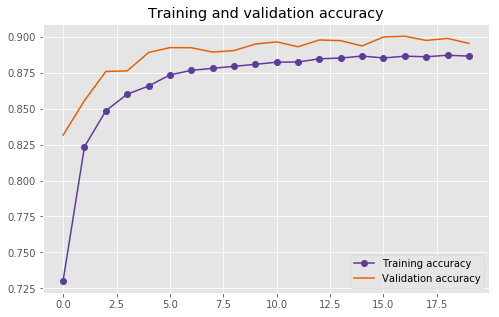

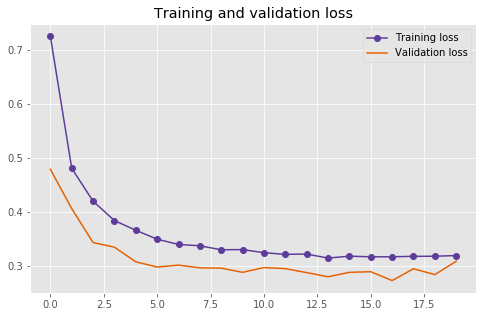

In [163]:
y_pred_cnn_dropout = model.predict_classes(test_data)
print(classification_report(df_test.iloc[:, 0], y_pred_cnn_dropout, target_names=label_names))

plot_train_curve(history)

### Use data augmentation data for further potential improvement


In [171]:
from keras.preprocessing.image import ImageDataGenerator
batch_size, epochs = 32, 20
datagen = ImageDataGenerator( rotation_range=40, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             shear_range=0.2, 
                             zoom_range=0.2, 
                             horizontal_flip=True, 
                             fill_mode='nearest')
train_generator = datagen.flow(train_data,
                               train_label,                               
#                               class_mode='categorical',
                              batch_size=batch_size)
validation_generator = datagen.flow(val_data,
                                   val_label,
#                                     class_mode='categorical',
                                   batch_size=batch_size)
test_datagen = ImageDataGenerator() # data already scaled to 1/255
# train_datagen.fit(train_data)

In [168]:
help(datagen.flow)

Help on method flow in module keras.preprocessing.image:

flow(x, y=None, batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', subset=None) method of keras.preprocessing.image.ImageDataGenerator instance
    Takes numpy data & label arrays, and generates batches of
        augmented/normalized data.
    
    # Arguments
           x: data. Should have rank 4.
            In case of grayscale data,
            the channels axis should have value 1, and in case
            of RGB data, it should have value 3.
           y: labels.
           batch_size: int (default: 32).
           shuffle: boolean (default: True).
           seed: int (default: None).
           save_to_dir: None or str (default: None).
            This allows you to optionally specify a directory
            to which to save the augmented pictures being generated
            (useful for visualizing what you are doing).
           save_prefix: str (default: `''`). Prefix to use f

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(D_out, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.RMSprop(lr=1e-3))

history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_data) / 32, 
                              epochs=epochs)
score = model.evaluate(test_data, test_label, verbose=0)
print('CNN using Data Augumentation\n test accuracy={:.3f}, test loss={:.3f}'
          .format(score[1], score[0]))

## Using a pretrained model for further improvement
The fashion-MNIST dataset is relatively small compared with the massive Imagenet dataset, which has "14 million URLs of images have been hand-annotated by ImageNet to indicate what objects are pictured; in at least one million of the images, bounding boxes are also provided". 

Why use a pretrainied convet?

"A pretrained network is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computervision problems, even though these new problems may involve completely different classes than those of the original task." (from Deep learning with Python by **Francois Chollet**).

Keras has the following pretrained models:
- Xception ( Francois Chollet, Google)
- Inception V3 (C. Szegedy, Google)
- ResNet50 (Kaimin He, Facebook)
- VGG16 (Karen Simonyan and Andrew Zisserman, Oxford University)
- VGG19 (Karen Simonyan and Andrew Zisserman, Oxford University)
- MobileNet (Andrew G. Howard, Menglong Zhu et al., Google)

I will use VGG16 as an example. 

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weight='imagenet',
                 include_top=False,# need to use our own top layers
                 input_shape=(28, 28, 1))

conv_base.summary()

In [ ]:
# use datagen define previously

model = models.Squential()
model.add(conv_base) # pretrain model
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()
model.compile(optimzier=optimizers.RMSprop(lr=2e-5),
             loss='categorical_crossentropy',
             metrics=['acc'])
history = model.fit(
    train_generator, 
    epochs=30,
    batch_size=32,
    validaton_data=validation_generator)

score = model.evaluate(test_data, test_label, verbose=0)
print('CNN based on pretrained model\n test accuracy={:.3f}, test loss={:.3f}'
          .format(score[1], score[0]))